In [1]:
# Set the matplotlib magic. This line is specific to ipython notebooks.
%matplotlib inline
 
# Import some useful module.
import time
from matplotlib import pyplot as plt
from IPython.display import HTML

import numpy as np
from scipy.optimize import curve_fit

# Import the system module.
import mag_lev

Below we calculate a relationship between the permanent magnet distance and the hall voltage with no electromagnet by reading the voltage value at a set of known distances and creating a least squares 1/x^2 regression

Starting system...
System started
System stopped


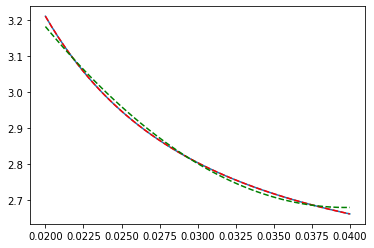

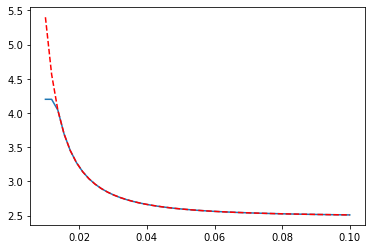

In [2]:
# calculating hall voltage vs permanent magnet distance
# Create the system object.
example_sys = mag_lev.MagLev()
example_sys.start_system()

example_sys.set_max_coil_voltage_magnitude(10.0)
example_sys.set_amplifier_input(0, example_sys.FORWARD)

# Choose an object mass.
example_sys.set_object_mass(3.0e-3)

#-----------------------------------------------------------------------------------

time_step = 0.1

def inv_sq(x, a, b):
    return a/((x)**2) + b

def quad(x, a, b, c):
    return a*x**2 + b*x + c

hallvalavg = []
distances = np.linspace(0.02, 0.04, 50)
for d in distances:
    example_sys.hold_magnet_at_distance(d)
    hallvals = []
    start_time = time.time()
    while time.time() - start_time < time_step:
        hallvals.append(example_sys.get_hall_voltage())

    hallvalavg.append(np.mean(hallvals))
    
x = np.array(distances)
y = np.array(hallvalavg)
[a_inv, _] = curve_fit(inv_sq, x, y)
[a_q, _] = curve_fit(quad, x, y)

plt.figure();
plt.plot(distances,hallvalavg)
plt.plot(distances, inv_sq(distances, a_inv[0], a_inv[1]), 'r--')
plt.plot(distances, quad(distances, a_q[0], a_q[1], a_q[2]), 'g--')


# quadratic is better so
test_points = np.linspace(0.01, 0.1, 50)
test_hallvals = []
for d in test_points:
    example_sys.hold_magnet_at_distance(d)
    test_hallvals.append(example_sys.get_hall_voltage())

plt.figure();
plt.plot(test_points, test_hallvals)
plt.plot(test_points, inv_sq(test_points, a_inv[0], a_inv[1]), 'r--')

example_sys.stop_system()

Now we calculate the linear relationship between the electromagnet voltage and the hall voltage. We can use those values to define the functions 2 cells below which act as our "lookup table" for hall voltage to a raw distance

Starting system...
System started
System stopped


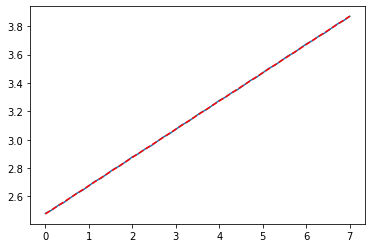

In [3]:
## calculating hall voltage vs electromagnet distance
# Create the system object.
sys = mag_lev.MagLev()
sys.start_system()

sys.set_max_coil_voltage_magnitude(10.0)

#-----------------------------------------------------------------------------------

time_step = 0.2

vhallvalavg = []
voltages = np.linspace(0, 7, 50)
for v in voltages:
    pwm = (v/10)*255
    sys.set_amplifier_input(pwm, sys.FORWARD)
    time.sleep(0.1)
    start_time = time.time()
    vhallvals = []
    while time.time() - start_time < time_step:
        vhallvals.append(sys.get_hall_voltage())

    vhallvalavg.append(np.mean(vhallvals))
    

[a_em, b_em] = np.polyfit(voltages, vhallvalavg, 1)
    
plt.plot(voltages, vhallvalavg)
plt.plot(voltages, (a_em*voltages + b_em), 'r--')
sys.stop_system()

In [4]:
def v_to_pwm(voltage, maxVoltage):
    # converts a voltage value to a PWM value to plug into the system
    pwm = round((voltage/maxVoltage)*255)
    return pwm

# voltage to distance
def hallv_dist(em_v, hall_v):
    # converts a hall voltage and electromagnet voltage to a distance
    h_em = a_em*em_v + b_em
    h_pm = hall_v - h_em + b_em
    x = np.sqrt(abs(a_inv[0]/(h_pm - a_inv[1])))
    return x

In [5]:
## Test Distance Calculation with input voltage

Vin = 5
trueDist = 0.03

# Generate system object.
sys = mag_lev.MagLev()
sys.start_system()
sys.set_max_coil_voltage_magnitude(10.0)
sys.set_amplifier_input(v_to_pwm(Vin,10), example_sys.FORWARD)
sys.set_object_mass(3.0e-3)
sys.hold_magnet_at_distance(trueDist)
time.sleep(1)

#-----------------------------------------------------------------------------------

time_step = 10
vhallvals = []

measuredDist = hallv_dist(Vin,sys.get_hall_voltage())
error = trueDist - measuredDist
print(f"Input Voltage: {Vin}")
print(f"True Distance: {trueDist}")
print(f"Measured Distance: {measuredDist}")
print(f"Error: {error}")

Starting system...
System started
Input Voltage: 5
True Distance: 0.03
Measured Distance: 0.02981249595200963
Error: 0.00018750404799037015


Starting system...
System started
85System stopped



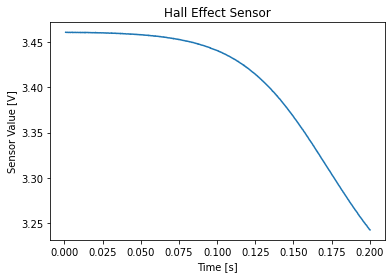

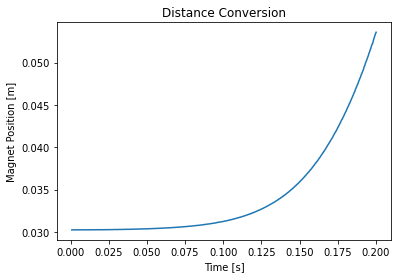

In [6]:
## Test Distance Calculation with input voltage

Vin = 3.32
trueDist = 0.03

# Generate system object.
sys = mag_lev.MagLev()
sys.start_system()
sys.set_max_coil_voltage_magnitude(10.0)
sys.set_amplifier_input(84, example_sys.FORWARD)
sys.set_object_mass(3.0e-3)
sys.hold_magnet_at_distance(trueDist)
# Wait a moment and then remove the magnet.
time.sleep(1)
sys.release_magnet()

# Watch what happens for a bit.

start_time = time.time()
end_time = .2
timevals = []
hallvals = []
xVals = []
while time.time() - start_time < end_time:
    hallvals.append(sys.get_hall_voltage())
    timevals.append(time.time() - start_time)

    
for val in hallvals:
    xVals.append(hallv_dist(Vin,val))
    

plt.figure()
plt.title("Hall Effect Sensor")
plt.xlabel("Time [s]")
plt.ylabel("Sensor Value [V]")
plt.plot(timevals,hallvals)
plt.figure()
plt.plot(timevals,xVals)
plt.title("Distance Conversion")
plt.xlabel("Time [s]")
plt.ylabel("Magnet Position [m]")

#----------------------------------

sys.stop_system()
print(v_to_pwm(Vin,10))

Now that we have a relationship between hall voltage and distance, we can find a second derivative for the function at different points in time in order to solve for our lumped parameters C below. We used Mathematica to solve the ODE given some values for x and the second derivative of x. 

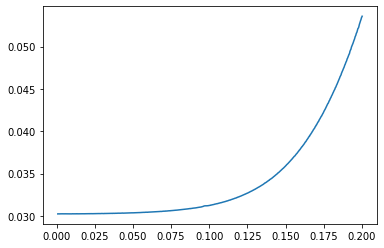

In [7]:
from scipy.interpolate import UnivariateSpline

y_spl = UnivariateSpline(timevals,xVals,s=0)

#plt.plot(timevals,xVals,'ro',label = 'data')
x_range = np.linspace(timevals[0],timevals[-1],1000)
plt.plot(x_range,y_spl(x_range))

Text(0.5, 1.0, 'Measured Acceleration')

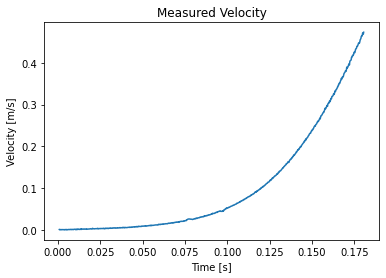

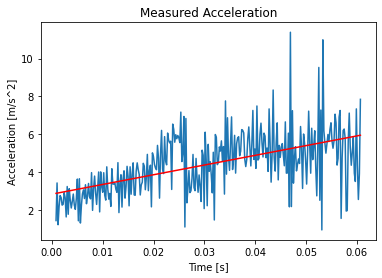

In [8]:
vel = y_spl.derivative(n=1)
accel = y_spl.derivative(n=2)
def running_mean(x, N):
    """ x == an array of data. N == number of samples per average """
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)
  
filteredVel = running_mean(vel(x_range), 100)
filteredAccel = running_mean(accel(x_range), 700)

z = np.polyfit(x_range[0:len(filteredAccel)],filteredAccel, 1)
zVals = []
for x in x_range[0:len(filteredAccel)]:
    zVals.append(z[0]*x+z[1])

plt.figure()
plt.plot(x_range[0:901],filteredVel)
plt.xlabel("Time [s]")
plt.ylabel("Velocity [m/s]")
plt.title("Measured Velocity")

plt.figure()
plt.plot(x_range[0:len(filteredAccel)],filteredAccel)
plt.plot(x_range[0:len(filteredAccel)],zVals,'r')
plt.xlabel("Time [s]")
plt.ylabel("Acceleration [m/s^2]")
plt.title("Measured Acceleration")

From here, we plugged our values into Mathematica to solve for our lumped parameter

In [9]:
C = .46*(8.70819*(10**-6))  #P2NA/4piLR  Assume right??

# System Parameters
x_0 = -0.03
#N = 20                    # Num Coils
mu_0 = (4*np.pi*10**(-7)) # Absolute permeability constant 
R = 2.41                 # Solenoid resistance [Ohms]
#L = 0.05                  # Solenoid length of coil [m]
m = 0.003                # Permanent magnet mass [kg]
g = 9.8                  # Acceleration due to gravity [m^2]          
#A = .01                   # Cross-sectional Area of Electromagnet Plunger [m^2]     

#P2NAL = .5*(m*g*(.03**2)*(4*np.pi)*(R/((85/255)*10)))
#Kv = (P2*N*A) / (4*np.pi*L*R) * (1/(x_0**2))
Kv = C *(1/(x_0**2))
K_nov = C*(1/(x_0**2))
Kx_nov = C*(2/(x_0**3)) 

v_0 = (m*g) / (x_0*Kx_nov - Kv + K_nov) 
K = C*(v_0/(x_0**2))
Kx = C* (2*v_0/(x_0**3))

print(v_0)

3.302737947290699


In [11]:
%matplotlib widget
# PD Controller Implementation

#System Params
#----------------------
magMass = 3.0e-3
maxVoltage = 10.0
xDesired = 0.03
vInit = -(magMass*g) / (xDesired*Kx_nov - Kv + K_nov)
Vin = vInit

#System Setup
#----------------------
sys = mag_lev.MagLev()
sys.start_system()
sys.set_max_coil_voltage_magnitude(maxVoltage)
sys.set_amplifier_input(v_to_pwm(vInit,maxVoltage), sys.FORWARD)
sys.set_object_mass(magMass)
sys.hold_magnet_at_distance(xDesired)
time.sleep(1)
#--------------------


Kp = 0.15
Kd = 0.01
gain = 2
 
eLast = 0
eMeasured = 0
xMeasured = 0
tLast = 0 
tCurrent = 0
dx = 0

xVals = []
tVals = []
contOuts = []
Vins = []
hallVals = []
sys.release_magnet()
timeStart = time.time()
while time.time()-timeStart<.4:
    tCurrent = time.time()-timeStart
    tVals.append(tCurrent)
    hall_v = sys.get_hall_voltage()
    hallVals.append(hall_v)
    xMeasured = hallv_dist(Vin, hall_v)
    xVals.append(xMeasured)
    eMeasured = xDesired-xMeasured
    
    de = eMeasured-eLast
    dt = tCurrent-tLast
    dedt = de/dt
    
    contOut = gain*(Kp*eMeasured + Kd*dedt)
    contOuts.append(contOut)
    Vin = min(max(vInit-contOut,0),10)
    Vins.append(Vin)
    sys.set_amplifier_input(v_to_pwm(Vin,maxVoltage), sys.FORWARD)
    
    tLast = tCurrent
    eLast = eMeasured

time.sleep(1)
sys.stop_system()
time.sleep(1)

plt.figure()
plt.title("Hall Effect Sensor")
plt.xlabel("Time [s]")
plt.ylabel("Sensor Value [V]")
plt.plot(tVals,hallVals)
plt.figure()
plt.plot(tVals,xVals)
plt.title("Distance Conversion")
plt.xlabel("Time [s]")
plt.ylabel("Magnet Position [m]")
plt.figure()
plt.plot(tVals,Vins)
plt.title("Electromagnet Voltage")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [v]")
plt.figure()
plt.plot(tVals,contOuts)
plt.title("Controller Output")
plt.xlabel("Time [s]")
plt.ylabel("Voltage [v]")


Starting system...
System started
System stopped


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Voltage [v]')

In [12]:
%matplotlib widget
anim = sys.create_system_animation();
anim_video = HTML(anim.to_html5_video())
anim_video


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …